# 1. Descarga y exploración del corpus

Hemos elegido el data set de reviews de instrumentos musicales que por el tamaño parece que vamos a poder tratarlo sin tener que sacar un sub set de el.

Lo primero que hacemos es descargarlo.

In [1]:
! wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz

--2022-07-03 10:35:52--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2460495 (2.3M) [application/x-gzip]
Saving to: ‘reviews_Musical_Instruments_5.json.gz’

reviews_Musical_Ins 100%[===================>]   2.35M  8.01MB/s    in 0.3s    

2022-07-03 10:35:52 (8.01 MB/s) - ‘reviews_Musical_Instruments_5.json.gz’ saved [2460495/2460495]



Una vez descargado deberemos extraer la información puesto que es un archivo compromido.

In [2]:
! gunzip -f reviews_Musical_Instruments_5.json.gz

Simplmente para hacer una comprobación rápida de que la descarga y la extracción ha ido correctamente visualizamos el contenido.

In [3]:
! head reviews_Musical_Instruments_5.json

{"reviewerID": "A2IBPI20UZIR0U", "asin": "1384719342", "reviewerName": "cassandra tu \"Yeah, well, that's just like, u...", "helpful": [0, 0], "reviewText": "Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,", "overall": 5.0, "summary": "good", "unixReviewTime": 1393545600, "reviewTime": "02 28, 2014"}
{"reviewerID": "A14VAT5EAX3D9S", "asin": "1384719342", "reviewerName": "Jake", "helpful": [13, 14], "reviewText": "The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smell

In [4]:
!pip install num2words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 101 kB 3.6 MB/s 


In [83]:
import unicodedata
import random
import gensim
import pandas as pd
import numpy as np
import multiprocessing as mp

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from collections import Counter

import nltk
from nltk import ngrams
from nltk import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer

from num2words import num2words

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.ensemble import GradientBoostingClassifier

from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Embedding,
    LSTM,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam

from keras.preprocessing import sequence

In [6]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

Cargamos en un DataFrame de Pandas la información del DataSet para comenzar a trabajar con el.

In [7]:
df = pd.read_json ('reviews_Musical_Instruments_5.json', lines=True)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


## Metodos con funciones genéricas para la exploración.

In [8]:
# Metodo para obtener el numero total de reviews
def total_number_of_reviews(df):
  return df.shape[0]

In [9]:
# Metodo para obtener el numero total de frases
def total_number_of_sentences(df):
  sentences = list()
  for review in df.values:
    for sentnce in review[0].split('.'):
      sentences.append(sentnce)

  return len(sentences)

In [10]:
# Metodo para obtener el numero total de tokens o palabras
def total_number_of_tokens(df):
  tokens = list()
  for review in df.values:
    for token in review[0].split():
      tokens.append(token)

  return len(tokens)

In [11]:
# Metodo para obtener los tokens o palabras
def extract_tokens_from_a_DataFrame(df):
  tokens = list()
  for review in df.values:
    for token in review[0].split():
      tokens.append(token)

  return tokens

In [12]:
# Metodo para generar un grafico de tipo nuve de palabras
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

## Distribución de reviews por número de estrellas

Mostraremos la distribucion de reviews totales por número de estrellas.

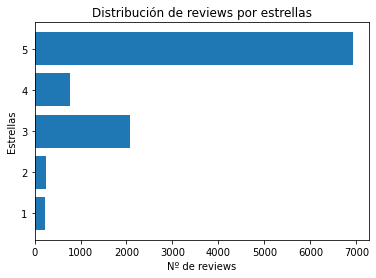

In [13]:
df_overall = df['overall']
count_to_stars = df_overall.value_counts()

stars = df_overall.unique()

plt.barh(stars, count_to_stars)
plt.title('Distribución de reviews por estrellas')
plt.xlabel('Nº de reviews')
plt.ylabel('Estrellas')
plt.show()

## Distribución de reviews positivas y negativas

Mostraremos la distribución entre reviews positivas y negativas. Para ello vamos a tomar como limite 3 estrellas. Todas aquellas reviews superiores a 3 serán positivas el resto negativas.

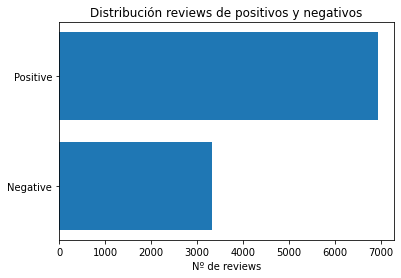

In [14]:
positive = len(df[df['overall'] > 4])
negative = len(df[df['overall'] <= 4])

total = len(df)

plt.barh(['Negative','Positive'],[negative, positive])
plt.title('Distribución reviews de positivos y negativos')
plt.xlabel('Nº de reviews')
plt.show()

Con la anterior gráfica, de reviews por estrellas ya podíamos ver que el DataSet estaba desbalanceado, pero con esta podemos afirmar que está muy desbalanceado.

Una posible solución sería tomar como referencia 4 para intentar equilibrar un poco los datos.

## Analisis del texto según viene del data set

Vamos hacer una primera exploración de los datos tal cual tenemos nos viene de DataSet.

In [15]:
numberReviews = total_number_of_reviews(df['reviewText'])
print(f'Tenemos un total de {numberReviews} reviews.')

Tenemos un total de 10261 reviews.


In [16]:
numberSentences = total_number_of_sentences(df[['reviewText']])
print(f'Tenemos un total de {numberSentences} frases.')

Tenemos un total de 74438 frases.


In [17]:
number_tokens = total_number_of_tokens(df[['reviewText']])
print(f'Tenemos un total de {number_tokens} palabras o tokens.')

Tenemos un total de 925371 palabras o tokens.


In [18]:
# Almacenaremos el total de los tokens
words_totals = extract_tokens_from_a_DataFrame(df[['reviewText']])

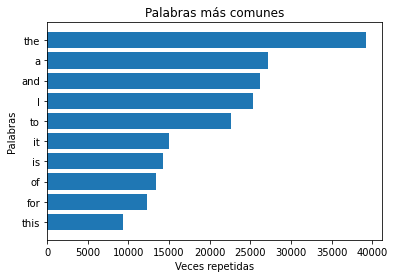

In [19]:
count_words = Counter(words_totals)
w_most_common = count_words.most_common(10)
words = [w[0] for w in w_most_common]
freqs = [w[1] for w in w_most_common]
freqs, words = zip(*sorted(zip(freqs, words)))
plt.barh(words, freqs)
plt.title('Palabras más comunes')
plt.xlabel('Veces repetidas')
plt.ylabel('Palabras')
plt.show()

Como era de suponer las palabras que mas se repiten son palabras que no nos van a portar información para el análisis. Vamos a reconfirmar que debemos realizar un procesado de datos obteniendo los bi y tri gramas. Y una nuebe de palabras.

In [20]:
# generamos los n-grams
bigrams_ = list(ngrams(words_totals, 2))
trigrams_ = list(ngrams(words_totals, 3))

# calculamos la frecuencias
bg_freq = FreqDist(bigrams_)
tg_freq = FreqDist(trigrams_)

bg_freq_most_common = bg_freq.most_common(10)
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]

tg_freq_most_common = tg_freq.most_common(10)
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]

bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

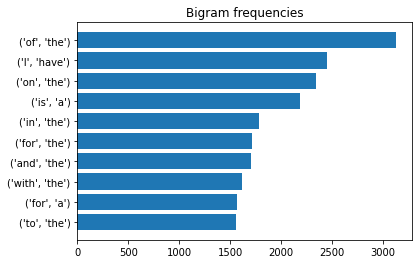

In [21]:
plt.barh(bgs_, bgs_f_)
plt.title('Bigram frequencies')
plt.show()

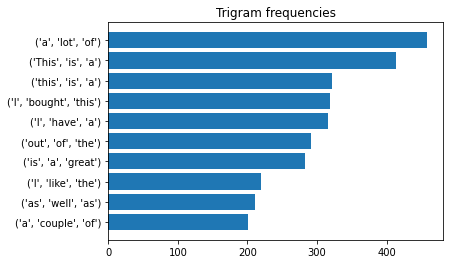

In [22]:
plt.barh(tgs_, tgs_f_)
plt.title('Trigram frequencies')
plt.show()

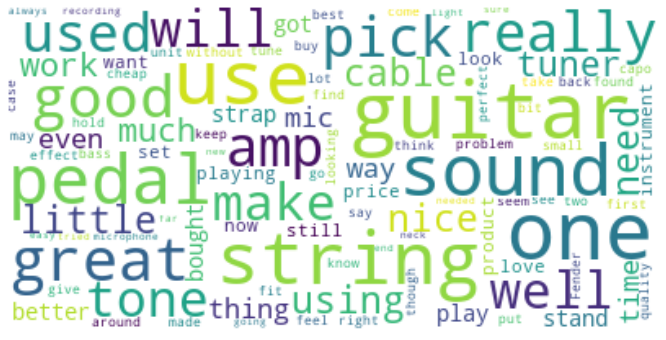

In [23]:
plot_word_cloud(words_totals)

## Analisis del texto eliminando las stop words

In [24]:
# Lista con las Stop Words
list_sw = _stop_words.ENGLISH_STOP_WORDS

In [25]:
# Almacenaremos el total de los tokens sin Stop Words
words_totals_no_sw = [word for word in words_totals if word not in list_sw]

El número de reviews y de frases será el mismo que antes pero el número de palabras es el que va a cambiar, así como los N-grams o la nuve de palabras, al eliminar las Stop Words de nuestras reviews.

In [26]:
print(f'Tenemos un total de {len(words_totals_no_sw)} palabras o tokens sin las Stop Words.')

Tenemos un total de 505711 palabras o tokens sin las Stop Words.


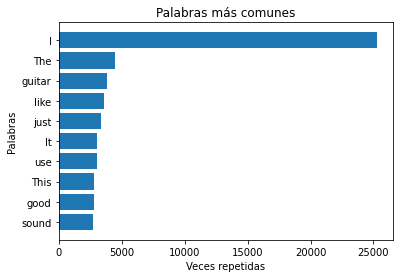

In [27]:
count_words_no_ws = Counter(words_totals_no_sw)
w_most_common = count_words_no_ws.most_common(10)
words = [w[0] for w in w_most_common]
freqs = [w[1] for w in w_most_common]
freqs, words = zip(*sorted(zip(freqs, words)))
plt.barh(words, freqs)
plt.title('Palabras más comunes')
plt.xlabel('Veces repetidas')
plt.ylabel('Palabras')
plt.show()

In [28]:
# N-grams

# generamos los n-grams
bigrams_no_sw = list(ngrams(words_totals_no_sw, 2))
trigrams_no_sw = list(ngrams(words_totals_no_sw, 3))

# calculamos la frecuencias
bg_freq_no_sw = FreqDist(bigrams_no_sw)
tg_freq_no_sw = FreqDist(trigrams_no_sw)

bg_freq_most_common_no_sw = bg_freq_no_sw.most_common(10)
bgs_no_sw = [str(bg[0]) for bg in bg_freq_most_common_no_sw]
bgs_f_no_sw = [bg[1] for bg in bg_freq_most_common_no_sw]

tg_freq_most_common_no_sw = tg_freq_no_sw.most_common(10)
tgs_no_sw = [str(tg[0]) for tg in tg_freq_most_common_no_sw]
tgs_f_no_sw = [tg[1] for tg in tg_freq_most_common_no_sw]

bgs_f_no_sw, bgs_no_sw = zip(*sorted(zip(bgs_f_no_sw, bgs_no_sw)))
tgs_f_no_sw, tgs_no_sw = zip(*sorted(zip(tgs_f_no_sw, tgs_no_sw)))

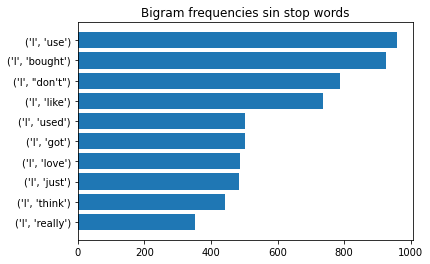

In [29]:
plt.barh(bgs_no_sw, bgs_f_no_sw)
plt.title('Bigram frequencies sin stop words')
plt.show()

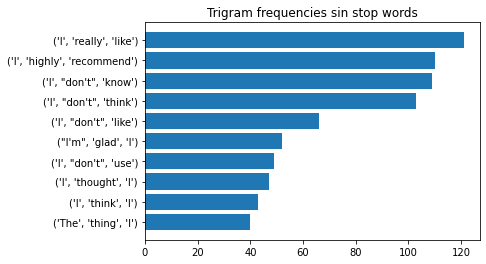

In [30]:
plt.barh(tgs_no_sw, tgs_f_no_sw)
plt.title('Trigram frequencies sin stop words')
plt.show()

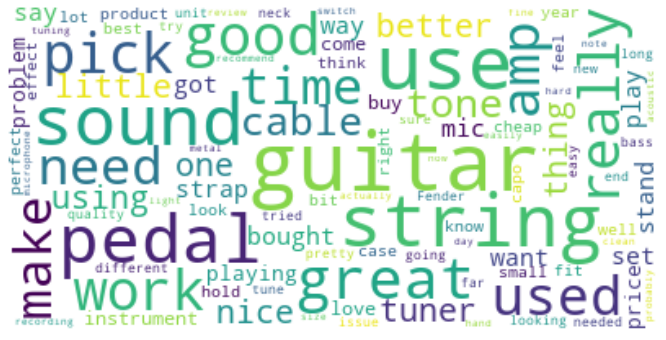

In [31]:
plot_word_cloud(words_totals_no_sw)

# 2. Etapa del procesado de texto

In [32]:
# Método eliminación de acentos, etc
def regularize_unicode(text):
  clean_text = ''
  clean_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return clean_text


# Método para eliminar stop words
def delete_stop_words(text, sw_list=_stop_words.ENGLISH_STOP_WORDS):
  clean_text = ''
  clean_text = ' '.join([word for word in text.lower().split() if word not in sw_list])
  return clean_text


# Método para regularizar en mayusculas o minusculas
def regularize_lowercase(text, tokenizer):
  clean_text = list()

  for word in tokenizer.tokenize(text):
    clean_word = word.lower()
    clean_text.append(clean_word)

  return ' '.join(clean_text)


# Método lematizar
def regularize_lemat(text, tokenizer, lemmatizer):
  clean_text = list()

  for word in tokenizer.tokenize(text):
    clean_word = lemmatizer.lemmatize(word)
    clean_text.append(clean_word)

  return ' '.join(clean_text)


# Método para eliminar espacios sobrantes
import string
def regularize_spaces(text):
  table = str.maketrans('', '', string.punctuation)
  clean_text = ' '.join([word.translate(table) for word in text.split()])
  return clean_text


# Método convertir dígitos a palabras
def regularize_convert_digits_to_words(text, tokenizer):
  clean_text = list()

  for word in tokenizer.tokenize(text):
    if word.isdigit():
      clean_word = num2words(word, lang='en')
      clean_text.append(clean_word)
    else:
      clean_text.append(word)

  return ' '.join(clean_text)
  

In [33]:
# Método de procesamiento general del texto
def pipeline_cleaner(text_list):

  clean_text = list()
  tokenizer = RegexpTokenizer(r'\w+')
  lemmatizer = WordNetLemmatizer()

  for i in range(len(text_list)):
    text_clean = regularize_unicode(text_list[i])
    text_clean = regularize_lowercase(text_clean, tokenizer)
    text_clean = delete_stop_words(text_clean)
    text_clean = regularize_lemat(text_clean, tokenizer, lemmatizer)
    text_clean = regularize_convert_digits_to_words(text_clean, tokenizer)
    text_clean = regularize_spaces(text_clean)
    clean_text.append(text_clean)

  return clean_text

In [34]:
reviews_text = pipeline_cleaner(df['reviewText'].tolist())
reviews_stars = df['overall']

df_model = pd.DataFrame({
    'review': reviews_text,
    'stars': reviews_stars
})
df_model.dropna(subset=['review', 'stars'], inplace=True)
df_model.reset_index(drop=True, inplace=True)

In [35]:
df_model.head()

,review,stars
0,write doe exactly s supposed filter pop sound ...,5
1,product doe exactly quite affordable did reali...,5
2,primary job device block breath produce poppin...,5
3,nice windscreen protects mxl mic prevents pop ...,5
4,pop filter great look performs like studio fil...,5


In [36]:
# Metodo por el que a partir de la puntuación lo convertimos en binario
def label_sentiment(row):
    if int(row['stars']) <= 4:
        return 1
    else:
        return 0

df_model['sentiment_label'] = df_model.apply(lambda row: label_sentiment(row), axis=1)

In [37]:
df_model.head()

,review,stars,sentiment_label
0,write doe exactly s supposed filter pop sound ...,5,0
1,product doe exactly quite affordable did reali...,5,0
2,primary job device block breath produce poppin...,5,0
3,nice windscreen protects mxl mic prevents pop ...,5,0
4,pop filter great look performs like studio fil...,5,0


Aquí tenemos un data frame con la información necesaria para trabajar en el resto de la practica, puesto que tenemos las reviews tratadas, las estrellas que han puesto en esa review y una nueva columna con el sentimiento a partir de las estrellas. 

Para intentar valancear un poco los datos hemos puesto como positivas únicamente las que están puntuadas con 5 estrella. Yo creo que lo ideal era a partir de 4 pero quedaría muy desbalanceado.

# 3. Etapa de entrenamiento y testeo de un modelo de análisis de sentimiento

Vamos a realizar el split de los datos con los que vamos a trabajar. El conjunto de datos no es muy grande por lo que solo vamos a dividir en Train y Test

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    df_model['review'],
    df_model['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [40]:
# Comprobamos que en la parte de data frame de entrenamiento tenemos solo los textos
X_train.iloc[:10]

9057    old ev mics little foam piece inside ball dry ...
9293    really play knob perfect tone able sort dial n...
1721    cheapy one tend break fairly easily one lasted...
7296    called lower priced brother enormous line six ...
5641    let s face m sure better compressor three four...
9251    review joyo crunch distortion od s including o...
6101    amazing m intermediate player thirty year tend...
6149    old school delay work simple use adjustment in...
7342                   nice pic s work really jammin tune
862     pretty flexible zero 60mm thickness recommend ...
Name: review, dtype: object

In [41]:
# Comprobamos que en la parte de data frame de etiquetas tenemos solo la parte binaria
y_train.iloc[:10]

9057    1
9293    1
1721    0
7296    0
5641    0
9251    0
6101    0
6149    0
7342    1
862     1
Name: sentiment_label, dtype: int64

Como vamos a trabajar con el sentimiento de los textos, en un clasificador, es buena practica utilizar n-gramas puesto que nos ayuda a contextualizar los textos y esto mejora las capacidades del modelo a la hora de predecir el sentimiento.

In [42]:
cv = CountVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=1000,
    strip_accents='ascii',
    ngram_range=(1, 3)
)
cv.fit(X_train)

CountVectorizer(max_df=0.95, max_features=1000, min_df=5, ngram_range=(1, 3),
                strip_accents='ascii')

In [43]:
# aplicamos el modelo entrenado a los datos para obtener su representacion 
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

## Análisis de sentimiento con ML (LogisticRegression)

Vamos a entrenar el modelo con varias configuraciones para ver cual tiene mejor rendimiento.

In [45]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

test_pred = list()
train_acc = list()
test_acc = list()

for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=1500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

    test_pred.append(test_predict)

Accuracy for C=0.01: 0.6995323460639127
Accuracy for C=0.05: 0.7217459080280593
Accuracy for C=0.25: 0.7186282151208107
Accuracy for C=0.5: 0.7135619641465316
Accuracy for C=1: 0.7084957131722526
Accuracy for C=10: 0.70576773187841
Accuracy for C=100: 0.7053780202650038
Accuracy for C=1000: 0.7049883086515978
Accuracy for C=10000: 0.7045985970381917


Viendo los resultados de los diferentes entrenamientos podemos ver que obtenemos el mejor resultado en la segunda iteracción. Vamos a sacar la información de ese modelo:

In [46]:
result_test_predict = test_pred[1]

print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, result_test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, result_test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, result_test_predict)))

Confussion matrix:
[[1563  166]
 [ 548  289]]

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81      1729
           1       0.64      0.35      0.45       837

    accuracy                           0.72      2566
   macro avg       0.69      0.62      0.63      2566
weighted avg       0.71      0.72      0.69      2566

Accuracy score:0.7217459080280593


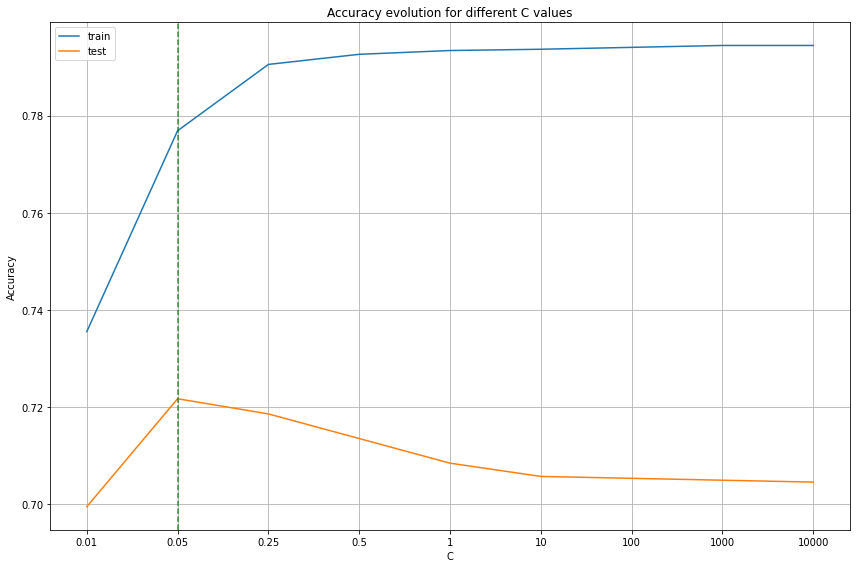

In [47]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

## Análisis de sentimiento con ML (GradientBoostingClassifier)

In [84]:
n_estimators = [8, 16, 32, 64, 128]

test_pred_clf = list()
train_acc_clf = list()
test_acc_clf = list()

for c in n_estimators:
    clf = GradientBoostingClassifier(n_estimators=c, learning_rate=1.0, max_depth=1, random_state=42)
    clf.fit(X_train_, y_train)
    
    train_predict = clf.predict(X_train_)
    test_predict = clf.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc_clf.append(accuracy_score(y_train, train_predict))
    test_acc_clf.append(accuracy_score(y_test, test_predict))

    test_pred_clf.append(test_predict)

Accuracy for C=8: 0.6940763834762276
Accuracy for C=16: 0.6948558067030397
Accuracy for C=32: 0.7034294621979735
Accuracy for C=64: 0.7077162899454403
Accuracy for C=128: 0.7053780202650038


In [85]:
result_test_predict = test_pred[3]

print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, result_test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, result_test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, result_test_predict)))

Confussion matrix:
[[1468  261]
 [ 474  363]]

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80      1729
           1       0.58      0.43      0.50       837

    accuracy                           0.71      2566
   macro avg       0.67      0.64      0.65      2566
weighted avg       0.70      0.71      0.70      2566

Accuracy score:0.7135619641465316


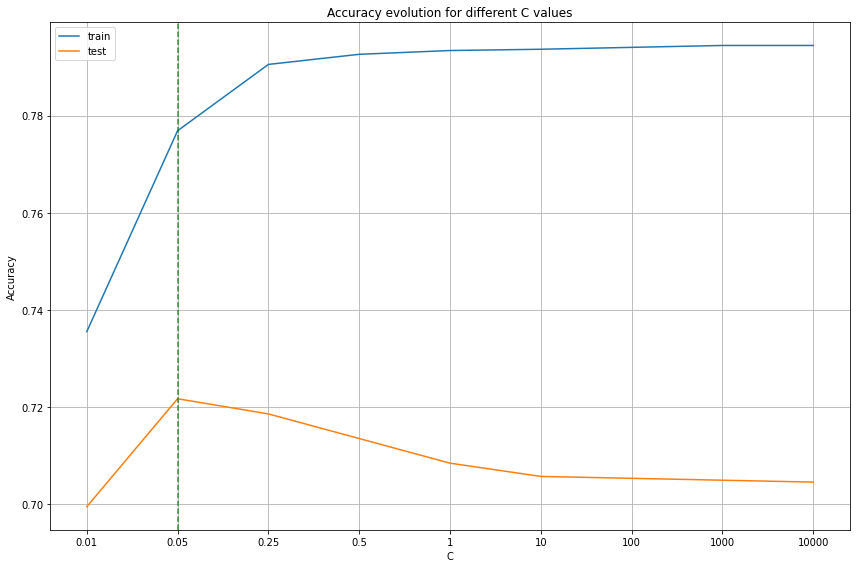

In [86]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

## Análisis de sentimiento con DL

### Metodos con funciones genéricas para el modelo de DL

In [51]:
def generate_tokenizer(train_df):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df)
    vocab_size = len(tokenizer.word_index) + 1
    print(f"Total words: {vocab_size}")
    return tokenizer, vocab_size

In [52]:
def generate_word2vec(train_df):
    documents = [_text.split() for _text in train_df.review]
    w2v_model = gensim.models.word2vec.Word2Vec(
        size=W2V_SIZE,
        window=W2V_WINDOW,
        min_count=W2V_MIN_COUNT,
        workers=mp.cpu_count(),
    )
    w2v_model.build_vocab(documents)

    words = w2v_model.wv.vocab.keys()
    vocab_size = len(words)
    print(f"Vocab size: {vocab_size}")
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

    return w2v_model

In [53]:
def generate_embedding(word2vec_model, vocab_size, tokenizer):
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    return Embedding(
        vocab_size,
        W2V_SIZE,
        weights=[embedding_matrix],
        input_length=SEQUENCE_LENGTH,
        trainable=False,
    )

### Modelo DL

In [54]:
# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
# 32
W2V_EPOCH = 5
W2V_MIN_COUNT = 2

# KERAS
SEQUENCE_LENGTH = 500

In [55]:
X_train_review = pd.DataFrame(X_train, columns=["review"])
X_test_review = pd.DataFrame(X_test, columns=["review"])

In [56]:
tokenizer, vocab = generate_tokenizer(X_train)

Total words: 15676


In [57]:
word2vec_model = generate_word2vec(X_test_review)

Vocab size: 4971


In [60]:
max_words = 500

X_train_words = sequence.pad_sequences(tokenizer.texts_to_sequences(X_train_review.review), maxlen=max_words)
X_test_words = sequence.pad_sequences(tokenizer.texts_to_sequences(X_test_review.review), maxlen=max_words)

In [61]:
embedding_layer = generate_embedding(word2vec_model, vocab, tokenizer)

Vamos a entrenar el modelo con varias configuraciones para ver cual tiene mejor rendimiento.

In [69]:
c_learning_rate = [1, 1e-2, 1e-4, 1e-6]
batch_size = 64
num_epochs = 1

test_pred_dl = list()
train_acc_dl = list()
test_acc_dl = list()
for c in c_learning_rate:
  model_custom = Sequential()
  model_custom.add(embedding_layer)
  model_custom.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  model_custom.add(Dense(1, activation="sigmoid"))

  model_custom.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=c), metrics=["accuracy"])

  model_custom.fit(X_train_words, y_train,
          validation_data=(X_test_words, y_test),
          batch_size=batch_size, epochs=num_epochs)
  
  # Evaluando el modelo de predicción con las imágenes de test
  train_predict = model_custom.predict(X_train_words).argmax(axis=-1)
  test_predict = model_custom.predict(X_test_words).argmax(axis=-1)

  train_acc_dl.append(accuracy_score(y_train, train_predict))
  test_acc_dl.append(accuracy_score(y_test, test_predict))

  test_pred_dl.append(test_predict)

121/121 [==============================] - 218s 2s/step - loss: 0.7235 - accuracy: 0.3281 - val_loss: 0.7131 - val_accuracy: 0.3262


In [77]:
result_test_predict_dl = test_pred_dl[1]

print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, result_test_predict_dl)))
print('\nClassification report:\n{}'.format(classification_report(y_test, result_test_predict_dl)))
print('Accuracy score:{}'.format(accuracy_score(y_test, result_test_predict_dl)))

Confussion matrix:
[[1729    0]
 [ 837    0]]

Classification report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.81      1729
           1       0.00      0.00      0.00       837

    accuracy                           0.67      2566
   macro avg       0.34      0.50      0.40      2566
weighted avg       0.45      0.67      0.54      2566

Accuracy score:0.6738113795791114


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Viendo los resultados de los diferentes entrenamientos podemos ver que obtenemos el mejor resultado en la segunda iteracción. Pero el modelo no es capaz de predecir el sentimiento negativo

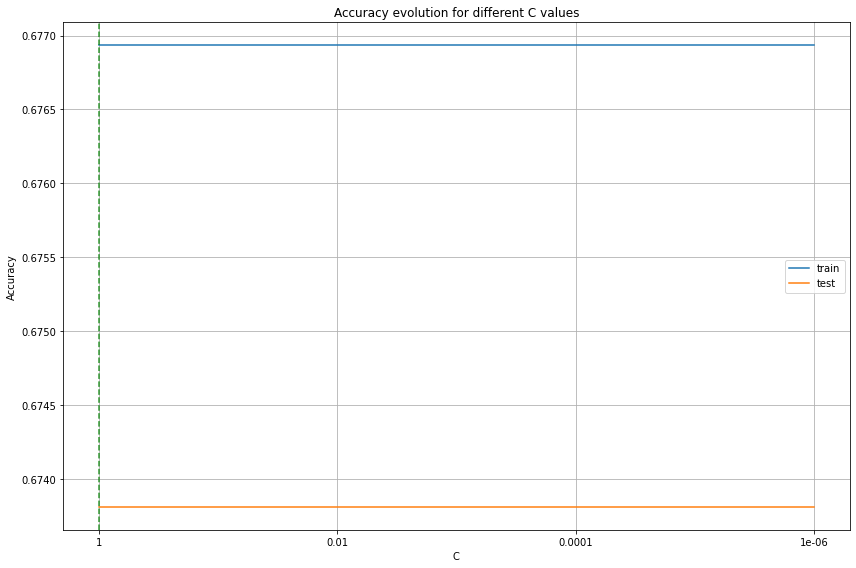

In [73]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc_dl, label='train')
plt.plot(test_acc_dl, label='test')
plt.axvline(np.argmax(test_acc_dl), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_learning_rate))), c_learning_rate)
plt.tight_layout()
plt.show()

# 4. Reporte de méticas y conclusiones

Vamos a trasladar aquí parte de la información que tenemos en el desarrollo de los modelos, para tener centralizadas las conclusiones.

Con el objetivo de ser capaces de predecir el sentimiento de una review hemos desarrollado dos modelo, uno con Machin Learning clasico y otro aplicando Deep Learning.

Parece que para el data set elegido, no es recomendable la utilización del modelo que hemos desarrollado en DL porque el modelo no es capaz de predecir el sentimiento negativo de las review, mientras que con el modelo de ML si somos capaces de predecir este tipo de sentimiento.

Como se puede observar mas abajo, incluso en el modelo ML, tambien tenemos problemas con el sentimiento negativo no es tan pronunciado pero vemos que es mucho menos preciso a la hora de predecirlo.

Inicialmente nos dimos cuenta de que el Data Set estaba muy desbalanceado hacia las reviews positivas, y creo que esto es lo que hace que no tengamos este problema final. ¿Por qué en DL es mucho mas acentuado? bajo mi punto de vista, es porque ademas de que tenemos este desbalanceo el data set no tiene el volumen suficiente como para que DL trabaje mejor que ML tradicional. Es posible que tambien falte ajustes de parámetros pero creo que despues de haber realizado algunas pruebas y no conseguir ningún tipo de resultado el problema principal es de volumen.

Despues de esta conclusión, hemos creido oportuno generar un modelo de ML con GradientBoostingClassifier para ver la diferencia y ver cual es el modelo que mejor nos va a funcionar.

**Modelo de ML de tipo Logistic Regresion**

In [78]:
result_test_predict = test_pred[1]

print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, result_test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, result_test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, result_test_predict)))

Confussion matrix:
[[1563  166]
 [ 548  289]]

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81      1729
           1       0.64      0.35      0.45       837

    accuracy                           0.72      2566
   macro avg       0.69      0.62      0.63      2566
weighted avg       0.71      0.72      0.69      2566

Accuracy score:0.7217459080280593


**Modelo DL**

In [79]:
result_test_predict_dl = test_pred_dl[1]

print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, result_test_predict_dl)))
print('\nClassification report:\n{}'.format(classification_report(y_test, result_test_predict_dl)))
print('Accuracy score:{}'.format(accuracy_score(y_test, result_test_predict_dl)))

Confussion matrix:
[[1729    0]
 [ 837    0]]

Classification report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.81      1729
           1       0.00      0.00      0.00       837

    accuracy                           0.67      2566
   macro avg       0.34      0.50      0.40      2566
weighted avg       0.45      0.67      0.54      2566

Accuracy score:0.6738113795791114


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
result_test_predict = test_pred[3]

print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, result_test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, result_test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, result_test_predict)))

Confussion matrix:
[[1468  261]
 [ 474  363]]

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80      1729
           1       0.58      0.43      0.50       837

    accuracy                           0.71      2566
   macro avg       0.67      0.64      0.65      2566
weighted avg       0.70      0.71      0.70      2566

Accuracy score:0.7135619641465316


**Mejor modelo es ML con LogisticRegression**

Despues de descartar el modelo de DL, entre los dos modelos de ML que hemos implementado nos vamos a quedar con el que está implementado con Regresión Logística, puesto que a pesar ser capaz de detectar un poco menos del sentimiento negativo tiene mejores datos de manera general y de precisión.

# 5. Modelo seleccionado para probarlo.

In [101]:
modelo_ok = LogisticRegression(C=0.05, solver='lbfgs', max_iter=1500)
modelo_ok.fit(X_train_, y_train)

LogisticRegression(C=0.05, max_iter=1500)

In [110]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df_model.iloc[review_index]['sentiment_label']))
    r = df_model.iloc[review_index]['review']
    print('Prediction: {}'.format(modelo_ok.predict(cv.transform([r]))))

In [111]:
for i in random.sample(range(0, len(df_model)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 6809
Actual sentiment: 1
Prediction: [1]

Review no. 245
Actual sentiment: 0
Prediction: [0]

Review no. 7274
Actual sentiment: 1
Prediction: [0]

Review no. 5402
Actual sentiment: 0
Prediction: [0]

Review no. 3668
Actual sentiment: 1
Prediction: [0]
